### Over and under fitting


[Source](https://www.kaggle.com/code/jhoward/getting-started-with-nlp-for-absolute-beginners)

To explain the motivation, let's start simple, and imagine we're trying to fit a model where the true relationship is this quadratic:

In [1]:
def f(x): return -3*x**2 + 2*x + 20

Unfortunately matplotlib (the most common library for plotting in Python) doesn't come with a way to visualize a function, so we'll write something to do this ourselves:

In [2]:
import numpy as np, matplotlib.pyplot as plt

def plot_function(f, min=-2.1, max=2.1, color='r'):
    x = np.linspace(min,max, 100)[:,None]
    plt.plot(x, f(x), color)

Here's what our function looks like:

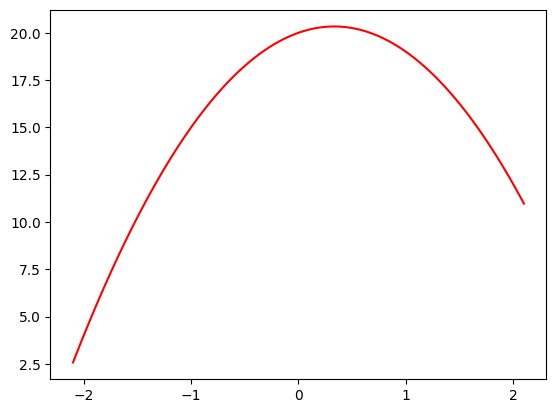

In [3]:
plot_function(f)

For instance, perhaps we've measured the height above ground of an object before and after some event. The measurements will have some random error. We can use numpy's random number generator to simulate that. I like to use seed when writing about simulations like this so that I know you'll see the same thing I do:

In [4]:
from numpy.random import normal,seed,uniform
np.random.seed(42)

Here's a function add_noise that adds some random variation to an array:

In [5]:
def noise(x, scale): return normal(scale=scale, size=x.shape)
def add_noise(x, mult, add): return x * (1+noise(x,mult)) + noise(x,add)

Let's use it to simulate some measurements evenly distributed over time:

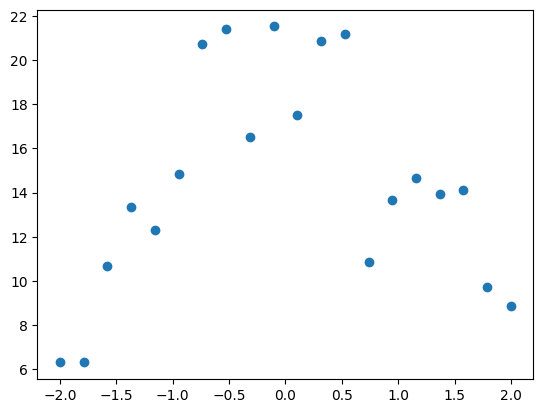

In [6]:
x = np.linspace(-2, 2, num=20)[:,None]
y = add_noise(f(x), 0.2, 1.3)
plt.scatter(x,y);

Now let's see what happens if we underfit or overfit these predictions. To do that, we'll create a function that fits a polynomial of some degree (e.g. a line is degree 1, quadratic is degree 2, cubic is degree 3, etc). The details of how this function works don't matter too much so feel free to skip over it if you like! (PS: if you're not sure about the jargon around polynomials, here's a great video which teaches you what you'll need to know.)

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def plot_poly(degree):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(x, y)
    plt.scatter(x,y)
    plot_function(model.predict)

So, what happens if we fit a line (a "degree 1 polynomial") to our measurements?

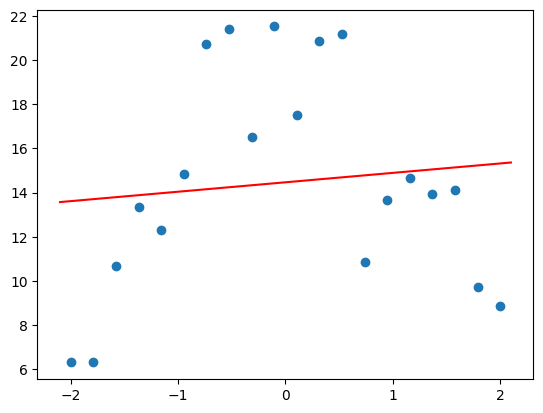

In [8]:
plot_poly(1)

As you see, the points on the red line (the line we fitted) aren't very close at all. This is under-fit -- there's not enough detail in our function to match our data.

And what happens if we fit a degree 10 polynomial to our measurements?

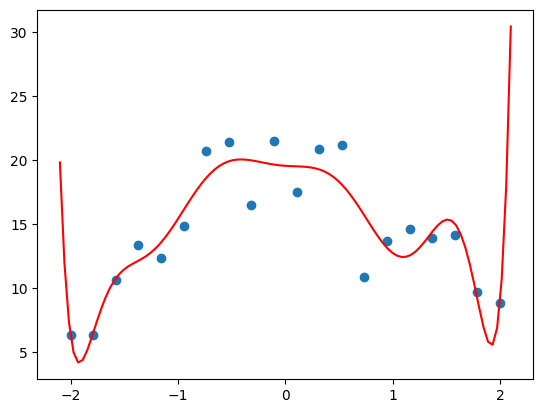

In [9]:
plot_poly(10)

Well now it fits our data better, but it doesn't look like it'll do a great job predicting points other than those we measured -- especially those in earlier or later time periods. This is over-fit -- there's too much detail such that the model fits our points, but not the underlying process we really care about.

Let's try a degree 2 polynomial (a quadratic), and compare it to our "true" function (in blue):

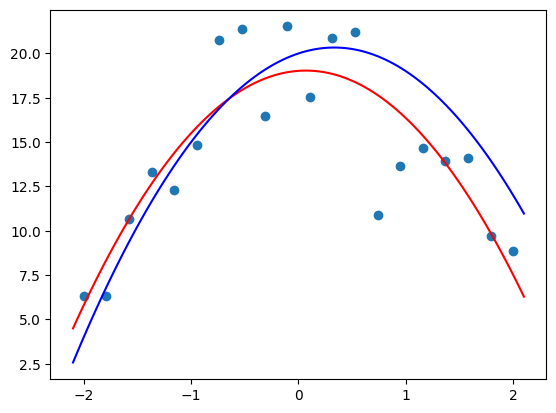

In [10]:
plot_poly(2)
plot_function(f, color='b')

That's not bad at all!

So, how do we recognise whether our models are under-fit, over-fit, or "just right"? We use a validation set. This is a set of data that we "hold out" from training -- we don't let our model see it at all. If you use the fastai library, it automatically creates a validation set for you if you don't have one, and will always report metrics (measurements of the accuracy of a model) using the validation set.

The validation set is only ever used to see how we're doing. It's never used as inputs to training the model.

### Train test validation

In [11]:
from sklearn.model_selection import train_test_split
data = [1,2,3,4,5,6]
train_test_split(data) #>  [[1, 6, 4, 2], [5, 3]]


[[5, 4, 6, 2], [1, 3]]

In [12]:
train_test_split(data, shuffle=False) #obtain a non-shuffled split

[[1, 2, 3, 4], [5, 6]]

In [13]:
train_test_split(data, test_size=0.2, shuffle=False) #obtain a non-shuffled split

[[1, 2, 3, 4], [5, 6]]

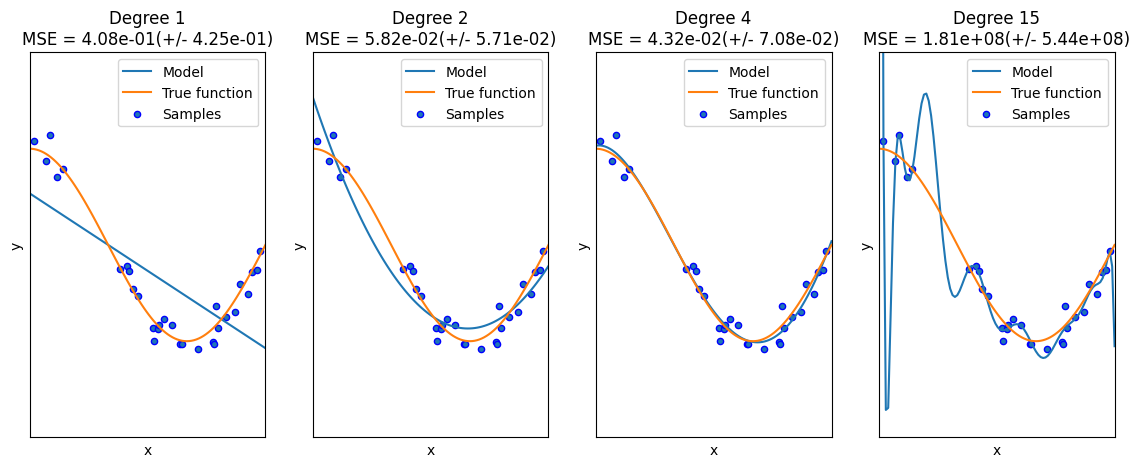

In [14]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures


def true_fun(X):
    return np.cos(1.5 * np.pi * X)


np.random.seed(0)

n_samples = 30
degrees = [1, 2, 4, 15]

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline(
        [
            ("polynomial_features", polynomial_features),
            ("linear_regression", linear_regression),
        ]
    )
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(
        pipeline, X[:, np.newaxis], y, scoring="neg_mean_squared_error", cv=10
    )

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor="b", s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title(
        "Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
            degrees[i], -scores.mean(), scores.std()
        )
    )
plt.show()